## Image classification using CNN => Detecting Pnuemonia from chest xray's

In [29]:
# Required Keras API's
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator

# Data processing
import numpy as np

# Sklearn for data split, performance evaluation
from sklearn.metrics import confusion_matrix

# For visulaizations
import matplotlib.pyplot as plt
import seaborn as sns

# Image operations 
import cv2

# Path operations
import os

import warnings
warnings.filterwarnings('ignore')

In [30]:
# Setting used labels and size of image
LABELS = ['PNEUMONIA', 'NORMAL']
IMG_SIZE = 150

In [31]:
############### DATASET STRUCTURE ###############

                # chest_xray
                  # train
                    # PNEUMONIA
                    # NORMAL
                  # test
                    # PNEUMONIA
                    # NORMAL
                  # val
                    # PNEUMONIA
                    # NORMAL
                    
def fetch_images(data_dir):
    data = [] 
    for class_ref, label in enumerate(LABELS): 
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)) # Reshaping images to preferred size
                data.append([resized_arr, class_ref])
            except Exception as e:
                pass
    return np.array(data)


In [32]:
# Fetching train, test, data from the dataset
train = fetch_images('chest_xray/train')
test = fetch_images('chest_xray/test')
val = fetch_images('chest_xray/val')

Text(0.5, 1.0, 'TRAIN DATA COUNT')

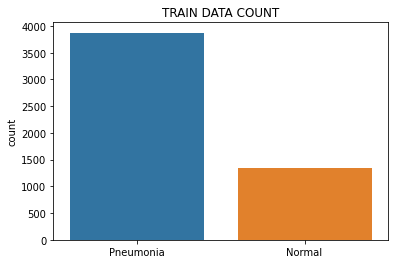

In [5]:
# Visualizing counts

train_count = ["Pneumonia" if i[1] == 0 else "Normal" for i in train]
test_count = ["Pneumonia" if i[1] == 0 else "Normal" for i in test]
val_count = ["Pneumonia" if i[1] == 0 else "Normal" for i in val]

# Train data count
sns.countplot(train_count).set_title('TRAIN DATA COUNT')

Text(0.5, 1.0, 'TEST DATA COUNT')

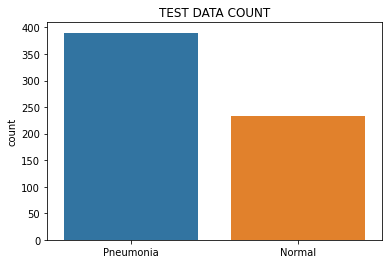

In [10]:
# Test data count
sns.countplot(test_count).set_title('TEST DATA COUNT')

Text(0.5, 1.0, 'VAL DATA COUNT')

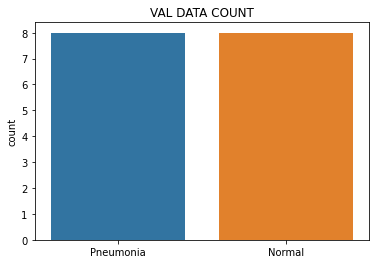

In [11]:
# Validation data count
sns.countplot(val_count).set_title('VAL DATA COUNT')

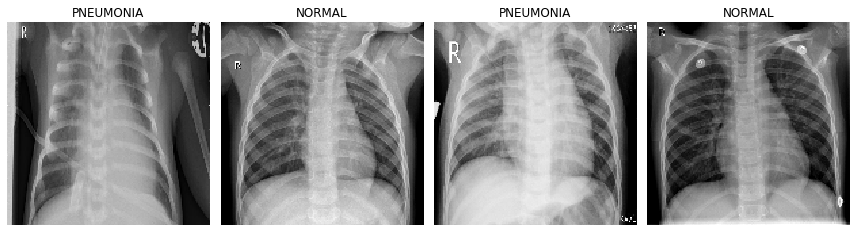

In [8]:
# Sample plots of xrays

sample_array = [train[1], train[-1], train[2], train[-2]]
plt.figure(figsize=(12, 12))
for index, data in enumerate(sample_array):
    plt.subplot(1, 4, index+1)
    image = data[0]        
    plt.title(LABELS[data[1]])
    plt.axis('off')
    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')

plt.tight_layout()
plt.show()

In [9]:
# x abd y split => x is the image matrix and y is the output label

# Train data
x_train = []
y_train = []
for image_matrix, label in train:
    x_train.append(image_matrix)
    y_train.append(label)

# Test data
x_test = []
y_test = []
for image_matrix, label in test:
    x_test.append(image_matrix)
    y_test.append(label)

# Validation data
y_val = []
x_val = []
for image_matrix, label in val:
    x_val.append(image_matrix)
    y_val.append(label)

In [10]:
# Normalize the data
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

In [11]:
# Resize data (4D)
x_train = x_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

In [12]:
# Image augementation
datagen = ImageDataGenerator(
        rotation_range = 30,
        zoom_range = 0.2,
        horizontal_flip = True,
        vertical_flip = False,
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False)  # divide each input by its std
datagen.fit(x_train)

In [13]:
# Model creation
model = Sequential()
model.add(Conv2D(32 , (3,3), activation = 'relu', padding='same', input_shape = (150,150,1)))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Conv2D(64 , (3,3), activation = 'relu', padding='same'))
model.add(Dropout(0.1))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(units = 1, activation = 'sigmoid'))

# Model compilation
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 92416)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [14]:
# Fitting model

history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/12
163/163 [==============================] - 92s 562ms/step - loss: 0.6174 - accuracy: 0.7592 - val_loss: 0.8858 - val_accuracy: 0.6875
Epoch 2/12
163/163 [==============================] - 90s 553ms/step - loss: 0.2571 - accuracy: 0.8916 - val_loss: 1.0216 - val_accuracy: 0.5625
Epoch 3/12
163/163 [==============================] - 90s 553ms/step - loss: 0.2287 - accuracy: 0.8997 - val_loss: 0.4266 - val_accuracy: 0.8125
Epoch 4/12
163/163 [==============================] - 92s 563ms/step - loss: 0.2050 - accuracy: 0.9151 - val_loss: 1.2900 - val_accuracy: 0.6250
Epoch 5/12
163/163 [==============================] - 91s 558ms/step - loss: 0.1971 - accuracy: 0.9198 - val_loss: 0.8902 - val_accuracy: 0.6875
Epoch 6/12
163/163 [==============================] - 91s 558ms/step - loss: 0.1803 - accuracy: 0.9279 - val_loss: 1.4012 - val_accuracy: 0.6250
Epoch 7/12
163/163 [==============================] - 91s 556ms/step - loss: 0.1620 - accuracy: 0.9403 - val_loss: 1.0548 - val_ac

In [15]:
# Accuracy calculation

print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 104ms/step - loss: 0.3011 - accuracy: 0.9135
Loss of the model is -  0.3011448085308075
20/20 [==============================] - 2s 106ms/step - loss: 0.3011 - accuracy: 0.9135
Accuracy of the model is -  91.34615659713745 %


Text(0, 0.5, 'Accuracy')

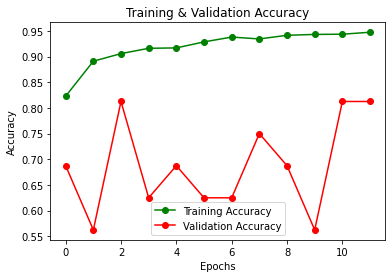

In [22]:
# Performance visualization

epochs = [i for i in range(12)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [27]:
# Predictions

predictions = model.predict_classes(x_test)

<AxesSubplot:>

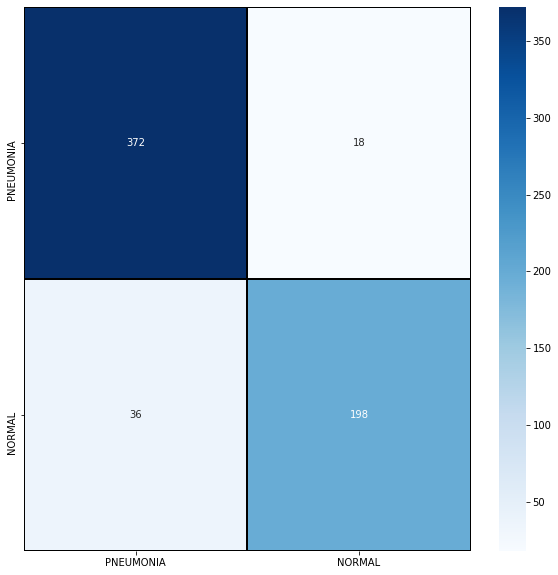

In [28]:
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix(y_test,predictions), cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = LABELS,yticklabels = LABELS)

### Reference

Dataset obtained from: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia